**NLP Assignment**


In [1]:
!pip install -q scikit-learn nltk spacy gensim matplotlib seaborn pandas numpy tqdm transformers datasets accelerate sentencepiece evaluate torch torchvision torchaudio --upgrade
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split

url = "/content/emotion-labels-test.csv"
df = pd.read_csv(url)

df.head()

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)

In [25]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')

stemmer = PorterStemmer()
def preprocess(text):
    tokens = word_tokenize(text.lower())
    stems = [stemmer.stem(token) for token in tokens]
    return " ".join(stems)

train_texts_stemmed = train_texts.apply(preprocess)
test_texts_stemmed = test_texts.apply(preprocess)

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_texts_stemmed)
X_test = vectorizer.transform(test_texts_stemmed)

clf = MultinomialNB()
clf.fit(X_train, train_labels)
preds = clf.predict(X_test)

print("Classical NLP Pipeline Performance:\n")
print(classification_report(test_labels, preds))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Classical NLP Pipeline Performance:

              precision    recall  f1-score   support

       anger       0.73      0.77      0.75       139
        fear       0.74      0.92      0.82       201
         joy       0.91      0.75      0.83       167
     sadness       0.74      0.57      0.65       122

    accuracy                           0.77       629
   macro avg       0.78      0.75      0.76       629
weighted avg       0.78      0.77      0.77       629



## Classical NLP Pipeline (Emotion Dataset)- task 2
This cell loads the HuggingFace `emotion` dataset (or lets you upload a CSV with `text` and `label` columns),
preprocesses text, vectorizes with TF-IDF, trains Logistic Regression, and evaluates performance.

## Transformer Pipeline (DistilBERT Fine-Tuning)- task 2
This cell fine-tunes DistilBERT on the same dataset and evaluates it.

In [6]:
from transformers import (
    BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

# Load and split data
url = "/content/emotion-labels-test.csv"
df = pd.read_csv(url)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)

# Assume train_texts/test_texts and train_labels/test_labels are already defined.
unique_labels = sorted(list(set(train_labels.tolist() + test_labels.tolist())))
label_map = {label: i for i, label in enumerate(unique_labels)}

train_labels_encoded = [label_map[label] for label in train_labels]
test_labels_encoded = [label_map[label] for label in test_labels]
train_dataset = Dataset.from_dict({'text': train_texts.tolist(), 'label': train_labels_encoded})
test_dataset = Dataset.from_dict({'text': test_texts.tolist(), 'label': test_labels_encoded})

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize(batch): return tokenizer(batch['text'], truncation=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(unique_labels))

# Key: mixed_precision (fp16), bigger batch, dynamic padding, fewer logging/checkpoints
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,  # Increase as memory allows
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    logging_steps=10,
    save_strategy="no",  # only save at the end
    report_to="none",
    fp16=True,  # Mixed precision
    dataloader_num_workers=10,  # Higher = faster batch prep (tune for your CPU)
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/2513 [00:00<?, ? examples/s]

Map:   0%|          | 0/629 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3414018460.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/da

Epoch,Training Loss,Validation Loss
1,0.439700,0.427591
2,0.212100,0.451028


Epoch,Training Loss,Validation Loss
1,0.439700,0.427591
2,0.212100,0.451028
3,0.038700,0.515307


TrainOutput(global_step=945, training_loss=0.4238722864912931, metrics={'train_runtime': 4603.5835, 'train_samples_per_second': 1.638, 'train_steps_per_second': 0.205, 'total_flos': 161163554288880.0, 'train_loss': 0.4238722864912931, 'epoch': 3.0})

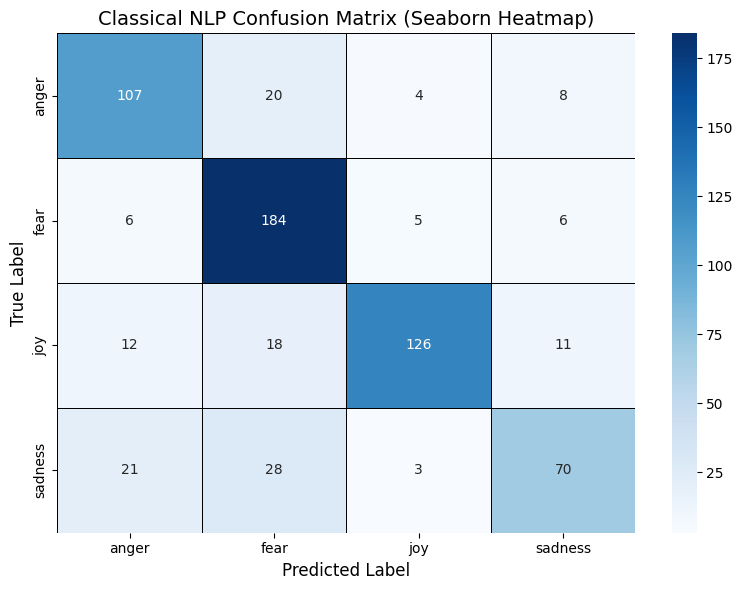

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
class_labels = np.sort(df['label'].unique()) # Get sorted unique labels
cm_classical = confusion_matrix(test_labels, preds, labels=class_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_classical,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True, # Display the color bar
    linewidths=0.5, # Add thin lines between cells
    linecolor='black',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("Classical NLP Confusion Matrix (Seaborn Heatmap)", fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
num_labels = len(pd.concat([df_train['label'], df_test['label']]).unique())

hf_train = Dataset.from_pandas(df_train[['text','label']].rename(columns={'label':'labels'}))
hf_test  = Dataset.from_pandas(df_test[['text','label']].rename(columns={'label':'labels'}))
hf_train = hf_train.map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=128), batched=True)
hf_test = hf_test.map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=128), batched=True)
hf_train.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
hf_test.set_format(type='torch', columns=['input_ids','attention_mask','labels'])

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
training_args = TrainingArguments(output_dir='./results', eval_strategy='epoch', save_strategy='epoch', learning_rate=2e-5,
    per_device_train_batch_size=16, per_device_eval_batch_size=32, num_train_epochs=2, weight_decay=0.01,
    logging_dir='./logs', load_best_model_at_end=True, metric_for_best_model='eval_loss')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {'accuracy': (preds == labels).mean(), 'f1_macro': f1_score(labels, preds, average='macro')}

trainer = Trainer(model=model, args=training_args, train_dataset=hf_train, eval_dataset=hf_test, tokenizer=tokenizer, compute_metrics=compute_metrics)
trainer.train()
trainer.evaluate()

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pkumar2804199 (pkumar2804199-bsbi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.247400,0.197039,0.921500,0.878751
2,0.142500,0.169740,0.925500,0.879710


{'eval_loss': 0.16974025964736938,
 'eval_accuracy': 0.9255,
 'eval_f1_macro': 0.8797101543184244,
 'eval_runtime': 6.6736,
 'eval_samples_per_second': 299.687,
 'eval_steps_per_second': 9.44,
 'epoch': 2.0}

Case **study** task 3

In [3]:
!pip install transformers datasets torch scikit-learn accelerate --upgrade

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

try:
    df_reviews = pd.read_csv("/content/amazon review dataset.csv", engine='python')
    df_reviews = df_reviews.sample(n=5000, random_state=42).reset_index(drop=True)
    print("Dataset loaded successfully.")
    print(df_reviews.head())
except FileNotFoundError:
    print("Error: /content/amazon review dataset.csv not found. Please upload the file to your Colab environment.")
    raise
except Exception as e:
     print(f"An error occurred during file loading: {e}")
     print("This might be due to a parsing error in the CSV file.")
     raise


def map_stars_to_sentiment(stars):
    if stars in [4, 5]:
        return 1 # positive
    elif stars in [1, 2]:
        return 0 # negative
    elif stars == 3:
        return 2 # neutral
    else:
        return -1 # unknown or invalid label

try:
    df_reviews['label'] = df_reviews['Score'].apply(map_stars_to_sentiment)
    df_reviews = df_reviews[df_reviews['label'] != -1].reset_index(drop=True)
    text_column = 'Text'
    label_column = 'label'

    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df_reviews[text_column], df_reviews[label_column], test_size=0.2, random_state=42, stratify=df_reviews[label_column]
    )

    train_labels = train_labels.astype(int)
    test_labels = test_labels.astype(int)

except KeyError as e:
    print(f"KeyError: {e}. Please check if 'Text' and 'Score' columns exist in your Reviews.csv file.")
    raise
except Exception as e:
     print(f"An error occurred during data splitting or label processing: {e}")
     raise


train_dataset = Dataset.from_dict({'text': train_texts.tolist(), 'label': train_labels.tolist()})
test_dataset = Dataset.from_dict({'text': test_texts.tolist(), 'label': test_labels.tolist()})


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
num_labels = df_reviews['label'].nunique()
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=1,
    report_to="none"
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

print("\nStarting training...")
trainer.train()

print("\nStarting evaluation...")
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Dataset loaded successfully.
       Id   ProductId          UserId             ProfileName  \
0  165257  B000EVG8J2  A1L01D2BD3RKVO  B. Miller "pet person"   
1  231466  B0000BXJIS  A3U62RE5XZDP0G                   Marty   
2  427828  B008FHUFAU   AOXC0JQQZGGB6         Kenneth Shevlin   
3  433955  B006BXV14E  A3PWPNZVMNX3PA             rareoopdvds   
4   70261  B007I7Z3Z0  A1XNZ7PCE45KK7                  Og8ys1   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     0                       0      5  1268179200   
1                     0                       0      5  1298937600   
2                     0                       2      3  1224028800   
3                     0                       1      2  1335312000   
4                     0                       2      5  1334707200   

                                        Summary  \
0  Crunchy & Good Gluten-Free Sandwich Cookies!   
1                            great kitty treats   
2     

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.303200,0.526642,0.848000
2,0.338200,0.479443,0.847000
3,0.430500,0.611737,0.856000
4,0.057800,0.688111,0.849000
5,0.033300,0.820906,0.849000
6,0.079800,0.884513,0.840000
7,0.085400,1.001405,0.839000
8,0.000600,1.010025,0.833000



Starting evaluation...


Evaluation Results: {'eval_loss': 1.010025143623352, 'eval_accuracy': 0.833, 'eval_runtime': 3.4839, 'eval_samples_per_second': 287.032, 'eval_steps_per_second': 35.879, 'epoch': 8.0}


In [37]:
texts = [
    "I got a flat tire on the way to the office this morning, utterly ruined the day",
    "This is the worst laptop I have ever bought.",
    "The product is okay, nothing special.",
    "The software crashes frequently but the design is nice."
]

inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(model.device)
outputs = model(**inputs)
preds = torch.argmax(outputs.logits, dim=1)
print("Predicted labels:", preds.tolist())


Predicted labels: [3, 2, 1, 0]


## Word2Vec Experiment task 4

In [2]:
import os
import pandas as pd

!pip install gensim

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

RSEED = 42 # Define RSEED here

csv_path = '/content/emotion-labels-test.csv'
if not os.path.exists(csv_path):
    from google.colab import files
    uploaded = files.upload()
    csv_path = list(uploaded.keys())[0]

df_reviews = pd.read_csv(csv_path)
text_col = 'review_text' if 'review_text' in df_reviews.columns else df_reviews.columns[0]
sentences = df_reviews[text_col].dropna().astype(str).apply(lambda x: simple_preprocess(x, deacc=True)).tolist()
w2v = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=5, workers=4, sg=1, seed=RSEED)

# Semantic similarity (cosine distance under the hood)
def safe_similar(word, topn=5):
    if word in w2v.wv:
        return w2v.wv.most_similar(word, topn=topn)
    else:
        return f"'{word}' not in vocabulary"

print("Similarity for 'happy':", safe_similar("happy"))
print("Similarity for 'sad':", safe_similar("sad"))

# Analogy example
try:
    print("Analogy test (king - man + woman):",
          w2v.wv.most_similar(positive=["king", "woman"], negative=["man"], topn=3))
except KeyError:
    print("Analogy example skipped (one of the words not in vocab).")

# Concrete Skip-gram vs CBOW example
context = ["I", "am", "very","exicted"]
target = "happy"

print("\nConcrete Examples:")
print("CBOW: Given context words", context, "→ predict target word:", target)
print("Skip-gram: Given target word", target, "→ predict likely context words:", context)

Similarity for 'happy': [('because', 0.9940476417541504), ('sometimes', 0.9939975738525391), ('like', 0.9938262701034546), ('depressing', 0.9937759637832642), ('discouraged', 0.9936957955360413)]
Similarity for 'sad': [('behind', 0.9973846077919006), ('question', 0.9972509145736694), ('very', 0.9971891641616821), ('hillary', 0.9971278309822083), ('forget', 0.9970834255218506)]
Analogy test (king - man + woman): [('hair', 0.9958868622779846), ('dismal', 0.9950693845748901), ('possible', 0.9950497150421143)]

Concrete Examples:
CBOW: Given context words ['I', 'am', 'very', 'exicted'] → predict target word: happy
Skip-gram: Given target word happy → predict likely context words: ['I', 'am', 'very', 'exicted']


Mini Project Task -5

Text 1: I feel so anxious and stressed all the time.
Label: 1

Text 2: Life is good, I am happy and energetic!
Label: 0

Text 3: I can't sleep, I feel hopeless and tired.
Label: 1

Text 4: Everything is fine, just a normal day.
Label: 0

Text 5: I feel sad and lonely, nothing seems to help.
Label: 1

Text 6: Had a fun day with friends, feeling great!
Label: 0

Text 7: I am constantly worried about everything.
Label: 1

Text 8: Work is exhausting but manageable.
Label: 0

Text 9: I feel depressed and unmotivated to do anything.
Label: 1

Text 10: Had a relaxing day, feeling peaceful.
Label: 0

=== Model Evaluation Metrics ===
F1 Score: 0.67
ROC-AUC Score: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67   

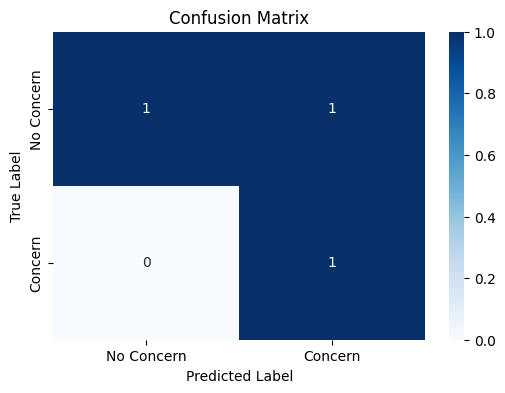

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    "text": [
        "I feel so anxious and stressed all the time.",
        "Life is good, I am happy and energetic!",
        "I can't sleep, I feel hopeless and tired.",
        "Everything is fine, just a normal day.",
        "I feel sad and lonely, nothing seems to help.",
        "Had a fun day with friends, feeling great!",
        "I am constantly worried about everything.",
        "Work is exhausting but manageable.",
        "I feel depressed and unmotivated to do anything.",
        "Had a relaxing day, feeling peaceful."
    ],
    "label": [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
}

for i, text in enumerate(data['text']):
    print(f"Text {i+1}: {text}")
    print(f"Label: {data['label'][i]}")
    print()
df = pd.DataFrame(data)

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression()
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)
y_pred_prob = model.predict_proba(X_test_vec)[:, 1]

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
cm = confusion_matrix(y_test, y_pred)

print("=== Model Evaluation Metrics ===")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Concern", "Concern"], yticklabels=["No Concern", "Concern"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
